# Comparison to other photometric fits

What do we observe if we compare our optimized models to that obtained by Sandor (we'll throw an assertion error here if we don't have a closer than 1 arcsecond match between our galaxy and anything in his catalog)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import json
import pandas as pd
from copy import deepcopy
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt
import lib.galaxy_utilities as gu
import lib.python_model_renderer.render_galaxy as rg
import lib.python_model_renderer.parse_annotation as pa
from best_individual_classifications import get_best_classification
from model_fitting import Model, ModelFitter

In [3]:
import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

In [4]:
plt.style.use('seaborn-dark')

In [5]:
with open('lib/best-classifications.json') as f:
    best_cls = json.load(f)

In [6]:
to_iter = pd.read_csv('lib/subject-id-list.csv').values[:, 0]

In [7]:
sd = pd.read_csv('lib/Kruk2018_Table2_Table3.csv')
s_keys = [
  'ra', 'dec', 'Fit_components',
  'r_disc', 're_disc', 'ba_disc',
  'r_bulge', 're_bulge', 'ba_bulge', 'n_bulge',
  'r_bar', 're_bar', 'ba_bar', 'n_bar',
]

In [8]:
sd_gals = []
coords = SkyCoord(ra=sd['ra']*u.degree, dec=sd['dec']*u.degree)
for subject_id in to_iter:
    gal, angle = gu.get_galaxy_and_angle(subject_id)
    sep = coords.separation(SkyCoord(ra=gal['RA']*u.degree, dec=gal['DEC']*u.degree))
    idxmin_sep = np.argmin(sep)
    if sep[idxmin_sep] < 1 * u.arcsec:
        sd_gals.append([subject_id, sd.iloc[idxmin_sep]])

In [20]:
out = []
for subject_id in to_iter:
    gal, angle = gu.get_galaxy_and_angle(subject_id)
    sep = coords.separation(SkyCoord(ra=gal['RA']*u.degree, dec=gal['DEC']*u.degree))
    idxmin_sep = np.argmin(sep)
    if not sep[idxmin_sep] < 1 * u.arcsec:
        continue
    print(subject_id)
    pic_array, deprojected_image = gu.get_image(gal, subject_id, angle)
    psf = gu.get_psf(subject_id)
    diff_data = gu.get_image_data(subject_id)
    pixel_mask = 1 - np.array(diff_data['mask'])[::-1]
    galaxy_data = np.array(diff_data['imageData'])[::-1]
    size_diff = diff_data['width'] / diff_data['imageWidth']
    # arcseconds per pixel for zooniverse image
    pix_size = pic_array.shape[0] / (gal['PETRO_THETA'].iloc[0] * 4)
    # arcseconds per pixel for galaxy data
    pix_size2 = galaxy_data.shape[0] / (gal['PETRO_THETA'].iloc[0] * 4)
    
#     imshow_kwargs = {
#         'cmap': 'gray_r', 'origin': 'lower',
#         'extent': (
#             # left of image in arcseconds from centre
#             -pic_array.shape[0]/2 / pix_size,
#             pic_array.shape[0]/2 / pix_size,  # right...
#             -pic_array.shape[1]/2 / pix_size,  # bottom...
#             pic_array.shape[1]/2 / pix_size  # top...
#         ),
#     }
    try:
        c = gu.classifications.query(
            'classification_id == {}'.format(
                best_cls[str(subject_id)]
            )
        ).iloc[0]
    except KeyError:
        print('Failed: {}'.format(subject_id))
        continue
    a = json.loads(c['annotations'])
    model = pa.parse_annotation(a, size_diff=size_diff)

    no_spiral_model = deepcopy(model)
    no_spiral_model['spiral'] = []

    mf_nosp = ModelFitter(no_spiral_model, galaxy_data, psf, pixel_mask)
    md_nosp = mf_nosp.model

    new_nosp_model, res = mf_nosp.fit(options={'maxiter': 100})
    m0_nosp = Model(no_spiral_model, galaxy_data, psf, pixel_mask)
    m1_nosp = Model(new_nosp_model, galaxy_data, psf, pixel_mask)
    out.append([subject_id, m0_nosp, m1_nosp, sd.iloc[idxmin_sep]])
#     if len(out) > 10:
#         break

20902000
20902008
20902040
20902053
20902064
20902065
20902013
20902063
20902049
20902071
20901993
20902006
20902043
20902020
20902057
20902058
21097001
21096843
21096944
21096935
21096962
21096969
21096860
21686572
21686600
Failed: 21686600
21686523
21686510
21686529
21686587
Failed: 21686587
21686542
21686592
Failed: 21686592
21686582
21686594
Failed: 21686594
21686578
21686593
Failed: 21686593
21686549
21686569
21686499
21686586
Failed: 21686586


In [22]:
def make_dfs(m, s):
    c, _ = m.to_df()
    gzb_comps = '+'.join(
        i for i, j in zip(
            ('disc', 'bar', 'bulge'),
            ~np.isnan(c['axRatio'].values)
        ) if j
    )
    gzb_data = pd.Series([
        np.nan, np.nan, gzb_comps,
        *c.loc['disk'][['i0', 'rEff', 'axRatio']],
        *c.loc['bulge'][['i0', 'rEff', 'axRatio', 'n']],
        *c.loc['bar'][['i0', 'rEff', 'axRatio', 'n']],
    ], index=s_keys, name='GZB')
    return pd.concat((s[s_keys].rename('Sandor_fit'), gzb_data), axis=1, sort=False)

In [23]:
sids = [i[0] for i in out]
out2 = list(map(lambda o: make_dfs(o[2], o[3]), out))

In [24]:
df_ba_disc = pd.concat([
    df.loc['ba_disc'].rename(sids[i])
    for i, df in enumerate(out2)
    if not np.any(df.loc['ba_disc'].values == 0)
], axis=1, sort=False).transpose()

df_ba_bulge = pd.concat([
    df.loc['ba_bulge'].rename(sids[i])
    for i, df in enumerate(out2)
    if not np.any(df.loc['ba_bulge'].values == 0)
], axis=1, sort=False).transpose()

df_ba_bar = pd.concat([
    df.loc['ba_bar'].rename(sids[i])
    for i, df in enumerate(out2)
    if not np.any(df.loc['ba_bar'].values == 0)
], axis=1, sort=False).transpose()

In [25]:
df_re_disc = pd.concat([
    df.loc['re_disc'].rename(sids[i])
    for i, df in enumerate(out2)
    if not np.any(df.loc['re_disc'].values == 0)
], axis=1, sort=False).transpose()

df_re_bulge = pd.concat([
    df.loc['re_bulge'].rename(sids[i])
    for i, df in enumerate(out2)
    if not np.any(df.loc['re_bulge'].values == 0)
], axis=1, sort=False).transpose()

df_re_bar = pd.concat([
    df.loc['re_bar'].rename(sids[i])
    for i, df in enumerate(out2)
    if not np.any(df.loc['re_bar'].values == 0)
], axis=1, sort=False).transpose()

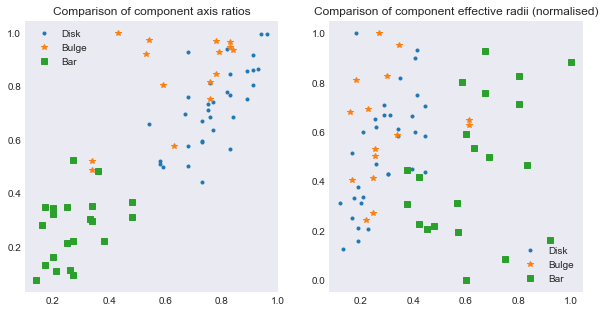

In [30]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(*df_ba_disc.values.T, '.', label='Disk')
plt.plot(*df_ba_bulge.values.T, '*', label='Bulge')
plt.plot(*df_ba_bar.values.T, 's', label='Bar')
plt.legend()
plt.title('Comparison of component axis ratios');

plt.subplot(122)
plt.plot(
    *df_re_disc.dropna().values.T / df_re_disc.dropna().values.max(),
    '.', label='Disk'
)
plt.plot(
    *df_re_bulge.dropna().values.T / df_re_bulge.dropna().values.max(),
    '*', label='Bulge'
)
plt.plot(
    *df_re_bar.dropna().values.T / df_re_bar.dropna().values.max(),
    's', label='Bar'
)
plt.legend()
plt.title('Comparison of component effective radii (normalised)');

In [16]:
import pickle
with open('sandor-comparisons.pickle', 'wb') as f:
    pickle.dump([sids, out2], f)

In [29]:
len(df_ba_disc), len(df_ba_bulge), len(df_ba_bar)

(33, 15, 33)